# Алгоритмы кластеризации


Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [84]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn import metrics
from itertools import cycle, islice
from sklearn.neighbors import KDTree

## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [85]:
class Clustering(BaseEstimator, ClusterMixin):
    def __init__(self, eps=1, min_pts = 4):
        
        self.eps = eps
        self.min_pts = min_pts

        
    def fit(self, x, y=None):
        self.x_len = len(x)
        self.labels = np.zeros(self.x_len)

        def neighbors(X, element, eps):
            nbrs = []
            for i in range(0, len(X)):
                if np.linalg.norm(X[element] - X[i]) < eps:
                    nbrs.append(i)
            return nbrs

        def expand_cluster(X, labels, P, C, eps, MinPts):
            Queue = [P]
            
            tree = KDTree(X, leaf_size=10)
            
            i = 0
            while i < len(Queue):
#            for i in range(0, len(Queue)):
                P = Queue[i]
#                NeighborPts = neighbors(X, P, eps)
                NeighborPts = tree.query_radius(X[P:(P+1)], r=eps)

                if len(NeighborPts[0]) < MinPts:
                    i += 1
                    continue
                for Pn in NeighborPts[0]:
                    if labels[Pn] == -1:
                        labels[Pn] = C
                    elif labels[Pn] == 0:
                        labels[Pn] = C
                        Queue.append(Pn)
                i += 1        

        def dbscan(X, eps, MinPts):
            labels = [0]*len(X)
            C = 0

            for P in range(0, len(X)):
                if not (labels[P] == 0):
                    continue
                NeighborPts = neighbors(X, P, eps)
                if len(NeighborPts) < MinPts:
                    labels[P] = -1
                else:
                    C += 1
                    labels[P] = C
                    expand_cluster(X, labels, P, C, eps, MinPts)
            return labels

        self.labels = dbscan(x, self.eps, self.min_pts)

        return self
  
    def predict(self, x):
        return self.labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

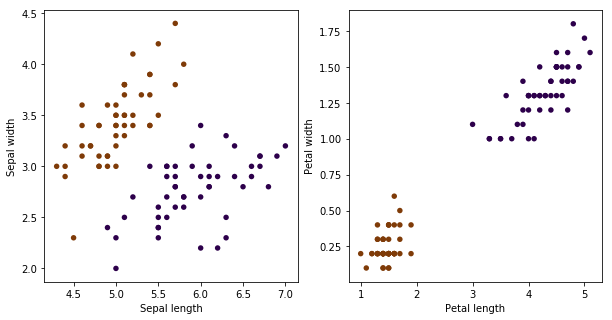

In [86]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [87]:
cl = Clustering()
pred_iris = cl.fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


## Подбор параметров модели

Подберем параметры модели используя Silhouette Coefficient

## Подбор min_pts 

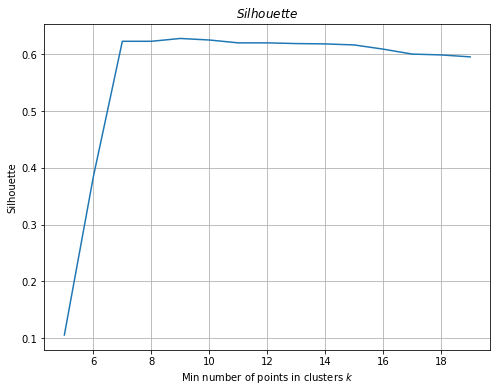

In [88]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)
ks = range(5, 20)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(eps=0.3, min_pts = k)
    y = cls.fit_predict(X)
    criteria[i] = metrics.silhouette_score(X,y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$Silhouette$")
pl.ylabel("Silhouette")
pl.xlabel("Min number of points in clusters $k$")
pl.grid()
pl.show()

## Подбор eps

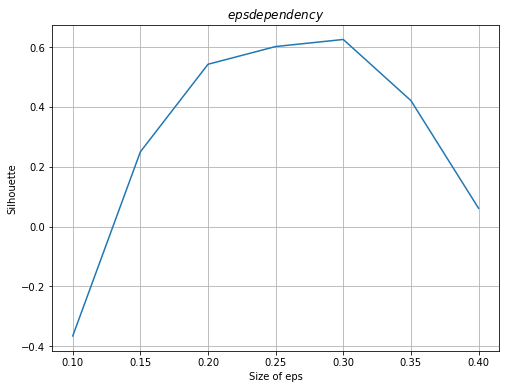

In [89]:
ks = np.arange(0.1,0.4,0.05)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(eps=k, min_pts = 10)
    y = cls.fit_predict(X)
    criteria[i] = metrics.silhouette_score(X,y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$eps dependency$")
pl.ylabel("Silhouette")
pl.xlabel("Size of eps")
pl.grid()
pl.show()


# Кластеризация данных

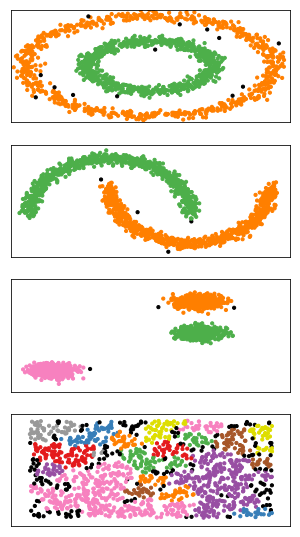

In [90]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    cls = Clustering(eps=0.15, min_pts = 10)
    y_pred = cls.fit_predict(X)
    plt.subplot(4, 1, i_dataset + 1)
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

# Дополнительное задание

## K-Means

In [127]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

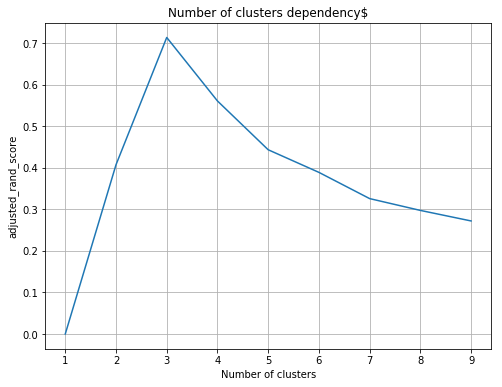

In [115]:
ks = np.arange(1,10,1)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = KMeans(n_clusters = k)
    y = cls.fit_predict(X)
    criteria[i] = metrics.adjusted_rand_score(labels_true,y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("Number of clusters dependency$")
pl.ylabel("adjusted_rand_score")
pl.xlabel("Number of clusters")
pl.grid()
pl.show()

In [116]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))


## Кластеризация данных с оптимальным параметром n_clusters = 3, на основе adjusted_rand_score

([], <a list of 0 Text yticklabel objects>)

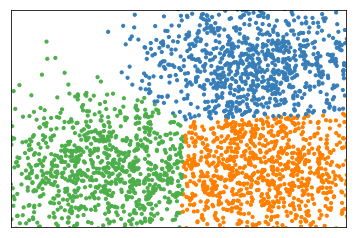

In [117]:
cls = KMeans(n_clusters = 3)
y = cls.fit_predict(X)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xticks(())
plt.yticks(())

In [118]:
metrics.adjusted_rand_score(labels_true,y)

0.7107945580509695

# Spectral Clustering

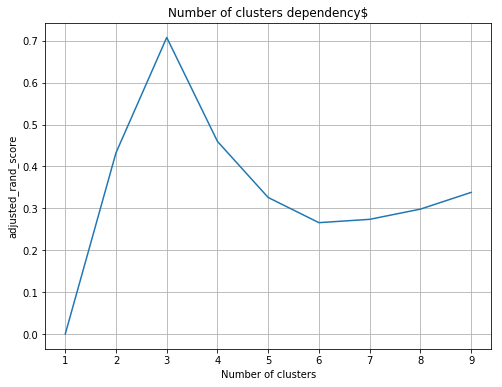

In [110]:
from sklearn.cluster import SpectralClustering
ks = np.arange(1,10,1)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = SpectralClustering(n_clusters = k)
    y = cls.fit_predict(X)
    criteria[i] = metrics.adjusted_rand_score(labels_true,y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("Number of clusters dependency$")
pl.ylabel("adjusted_rand_score")
pl.xlabel("Number of clusters")
pl.grid()
pl.show()

## SpectralClustering с оптимальным параметром кластеров

([], <a list of 0 Text yticklabel objects>)

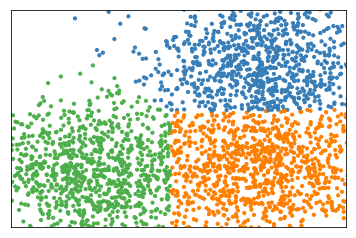

In [112]:
cls = SpectralClustering(n_clusters=3)
y = cls.fit_predict(X)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xticks(())
plt.yticks(())

## adjusted_rand_score в K-Means больше, чем в SpectralClustering

In [113]:
metrics.adjusted_rand_score(labels_true,y)

0.7079224200531873

# DBSCAN

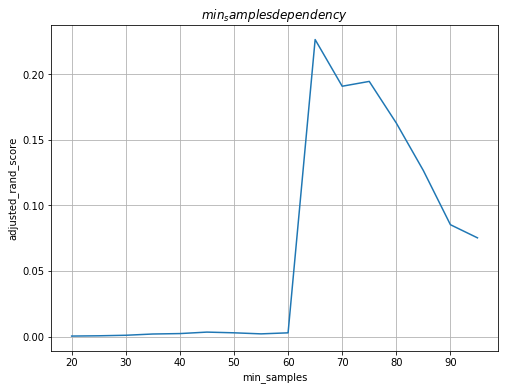

In [162]:
from sklearn.cluster import DBSCAN
#, cluster_optics_dbscan
ks = np.arange(20,100,5)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = DBSCAN(eps=0.3, min_samples=k)
    y = cls.fit_predict(X)
    criteria[i] = metrics.adjusted_rand_score(labels_true,y)
#    criteria[i] = metrics.adjusted_mutual_info_score(labels_true,y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$min_samples dependency$")
pl.ylabel("adjusted_rand_score")
pl.xlabel("min_samples")
pl.grid()
pl.show()

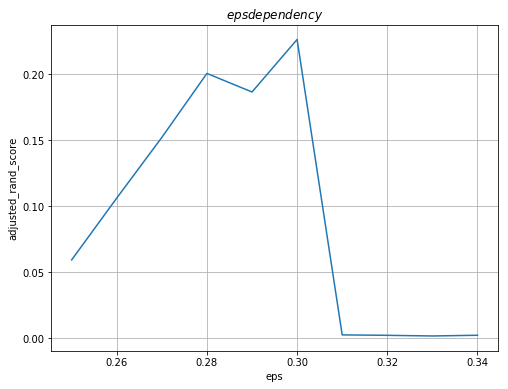

In [164]:
ks = np.arange(0.25,0.35,0.01)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = DBSCAN(eps=k, min_samples=65)
    y = cls.fit_predict(X)
    criteria[i] = metrics.adjusted_rand_score(labels_true,y)
#    criteria[i] = metrics.adjusted_mutual_info_score(labels_true,y)    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$eps dependency$")
pl.ylabel("adjusted_rand_score")
pl.xlabel("eps")
pl.grid()
pl.show()

## DBSCAN с оптимальными параметрами

([], <a list of 0 Text yticklabel objects>)

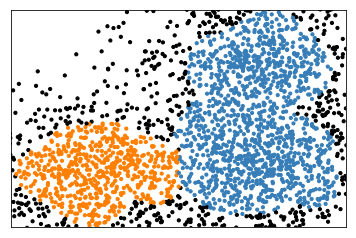

In [165]:
cls = DBSCAN(eps=0.3, min_samples=65)
y = cls.fit_predict(X)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xticks(())
plt.yticks(())

## DBSCAN отработал плохо на данном массиве данных - на 3 кластера на разбил

In [166]:
metrics.adjusted_rand_score(labels_true,y)

0.2264674214640427

# GMM


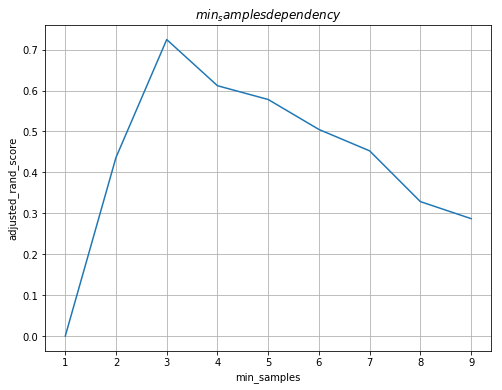

In [176]:
from sklearn import mixture
#, cluster_optics_dbscan
ks = np.arange(1,10,1)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    gmm = mixture.GaussianMixture(
        n_components=k, covariance_type='full')
#    cls = DBSCAN(eps=0.3, min_samples=k)
    y = gmm.fit_predict(X)
    criteria[i] = metrics.adjusted_rand_score(labels_true,y)
#    criteria[i] = metrics.adjusted_mutual_info_score(labels_true,y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$min_samples dependency$")
pl.ylabel("adjusted_rand_score")
pl.xlabel("min_samples")
pl.grid()
pl.show()

([], <a list of 0 Text yticklabel objects>)

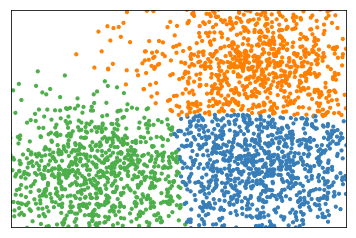

In [177]:

gmm = mixture.GaussianMixture(
        n_components=3, covariance_type='full')

y = gmm.fit_predict(X)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xticks(())
plt.yticks(())

In [178]:
metrics.adjusted_rand_score(labels_true,y)

0.7248020544171998